# LightGBM Quickstart for the *American Express - Default Prediction* competition

This notebook shows how to apply LightGBM to the competition data, and it introduces a space-efficient way of feature engineering.

It is based on the [EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense).

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'


In [38]:
##################
### RUN Parameters
###

INFERENCE = True            ### True for LOCAL RUN

ONLY_FIRST_FOLD = False      ### False for LOCAL RUN

USE_ALL_FEATURES = False     ### True for LOCAL RUN

DELETE_NON_RATIO_FEATURES = False

### - - - - - - - - - - - - - - - - - - - - - - - - -

IF_NOT_USE_ALL_FEATURES_THEN_USE = 'last_set'   ### Select one of: 'last_set' or 'top_impt_set' or 'minimal_set'

LEARNING_RATE = 0.03    ### Was 0.03
NUM_ESTIMATORS = 1200   ### Was 1200
RANDOM_SEED = 1         ### Was 1

### The data contains 1-13 monthly data profiles for each customer. We will use the first, last and nth1 and nth2 for modelling.
### Valid values for the next two variables are 0-12 where 0 is the first monthly data profile and 12 is the last (the 13th).
### IMPT: If the requested nth data profile does not exist for a customer then the "last" data profile will be used instead.
### IMPT: Use negative number references to have FEWER missed values for customers with less than 13 monthly data profiles.
VALUE_FOR_MONTH_NTH0 = 0   ### "FIRST" The selected monthly profile to be used for nth1 (was 4, -3, -9=4, -9, -10)
VALUE_FOR_MONTH_NTH1 = -10 ### The selected monthly profile to be used for nth1 (was 4, -3, -9=4, -9, -10)
VALUE_FOR_MONTH_NTH2 = -7  ### The selected monthly profile to be used for nth2 (was 8, -2, -5=8, -6, -7)
VALUE_FOR_MONTH_NTH3 = -4  ### The selected monthly profile to be used for nth2 (was            , -3, -4)
VALUE_FOR_MONTH_NTH4 = -1  ### "LAST" The selected monthly profile to be used for nth1 (was 4, -3, -9=4, -9, -10)

PCT_CALCULATION_DIVIDE_BY_LAST = True   ### If True then include "divide by last" (first/last, nth1/last, nth2/last) features
PCT_CALCULATION_DIVIDE_BY_NEXT = False  ### If True then include "divide by next" (first/nth1, nth1/nth2, nth2/last) features


DROP_SOME_TRAIN_DATA = False   ### NOT WORKING YET - causes errors

# FILL NAN VALUE
NAN_VALUE = 0 # WAS -127

In [22]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

**# Reading and preprocessing the data

We read the data from @raddar's [dataset](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format). @raddar has [denoised the data](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514) so that we can achieve better results with his dataset than with the original competition csv files.

Then we create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

The code has been optimized for memory efficiency rather than readability. In particular, `.iloc[mask_array, columns]` needs much less RAM than the groupby construction used in a previous version of the notebook.

Preprocessing for LightGBM is much simpler than for neural networks:
1. Neural networks can't process missing values; LightGBM handles them automatically.
1. Categorical features need to be one-hot encoded for neural networks; LightGBM handles them automatically.
1. With neural networks, you need to think about outliers; tree-based algorithms deal with outliers easily.
1. Neural networks need scaled inputs; tree-based algorithms don't depend on scaling.

In [23]:
train = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/train.parquet')
train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.979333,14,0.020818,0.828199,0.003487,0.090743,0.0,0.025139,...,-1,-1,-1,0,0,0.0,NaN,0,0.001498,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.984907,10,0.007209,0.812610,0.005904,0.079886,0.0,0.023691,...,-1,-1,-1,0,0,0.0,NaN,0,0.008225,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100503,0.0,0.012343,...,-1,-1,-1,0,0,0.0,NaN,0,0.006773,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802,0.0,0.008578,...,-1,-1,-1,0,0,0.0,NaN,0,0.001168,0


In [24]:
train[train['customer_ID'] == 'fffb0971619564cf6a4c01cf3014e42718555728b2988ec3340c37d64db23ca1']   ### has 1 month of data only

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
5531042,fffb0971619564cf6a4c01cf3014e42718555728b2988e...,2018-03-17,0.460419,0,0.006271,0.818968,0.006557,NaN,0.0,0.001899,...,-1,-1,-1,1,1,0.892102,0.160879,1,0.001988,1


In [25]:
#train['customer_ID'].iloc[0]
train[train['customer_ID'] == '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a']   ### has 13 months of data

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0,0.007863,1.005006,0.004220,0.110946,0.0,0.009866,...,-1,-1,-1,0,0,0.0,NaN,0,0.002223,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0,0.018859,1.008024,0.004509,0.103329,0.0,0.000783,...,-1,-1,-1,0,0,0.0,NaN,0,0.007661,0
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0,0.014324,1.000242,0.000263,0.108115,0.0,0.007836,...,-1,-1,-1,0,0,0.0,NaN,0,0.009616,0
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0,0.016888,1.003995,0.001789,0.102792,0.0,0.009817,...,-1,-1,-1,0,0,0.0,NaN,0,0.004369,0
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,NaN,0,0.004753,0


In [26]:
# train[train['customer_ID'] == '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a'].iloc[12]  ### if count is N then rows are iloc[0] to iloc[N-1]

# orig_length = len(train)
# print(str(orig_length))
# cutoff_point = orig_length // 2
# print(str(cutoff_point))

# train = train.sort_values(by=['customer_ID', 'S_2'], ascending=False)
# gc.collect()
# train

In [27]:
### Added

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile(f'../input/amex-data-integer-dtypes-parquet-format/train.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 10)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 

df.drop(columns=['customer_ID', 'S_2'], inplace=True)   ### These are not used in original code below
all_features = df.columns
print(str(len(all_features)))
print(str(all_features))

cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
cols=[col for col in df.columns if (col.startswith(('B'))) & (col not in cat_cols[:-1])]
### DROP R_ cols TO SAVE RAM for this test
df.drop(columns=cols, inplace=True)

all_features = df.columns
print(str(len(all_features)))
print(str(all_features))

del pf,first_ten_rows,df
gc.collect()

188
Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=188)
148
Index(['P_2', 'D_39', 'R_1', 'S_3', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45',
       'R_2',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=148)


1533

In [28]:
### ORIG
print('Original feature sets...')
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18',
                'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40',
                'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55',
                'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77',
                'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114',
                'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131',
                'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2',
                'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27',
                'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']

features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39',
                'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 
                'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 
                'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']

features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 
                'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42',
                'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63',
                'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105',
                'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125',
                'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145',
                'P_2', 'P_3', 'P_4', 
                'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 
                'S_3','S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27'
               ]

features_last_PATRIAL = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', #'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 
                 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', #'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38',
                 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', #'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51',
                 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', #'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71',
                 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', #'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106',
                 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', #'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133',
                 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', #'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7',
                 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', #'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7',
                 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', #'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27'
                ]

features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 
                 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38',
                 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51',
                 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71',
                 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106',
                 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133',
                 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7',
                 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7',
                 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27'
                ]

### BASED ON "gml AMEX Default Prediction EDA & LGBM Baseline" RUNS USING A SINGLE TYPES OF FEATURES (v6,v14,v13,v15,v12)
### If kept to 30 then will allow inference to be run within Kaggle RAM limits
features_top_impt = ['D_43', 'D_60', 'D_46', 'D_45', 'D_39', 'D_48', 'D_47', 'D_53', 'D_59', 'D_44', #'D_71', 'D_61', 'D_75', 'D_121', 'D_62',
                     'B_9', 'B_5', 'B_3', 'B_26', 'B_40', 'B_4', 'B_8', #'B_19', 'B_15', 'B_10', 'B_6', 'B_13',
                     'P_2', 'P_3', 'P_4', 
                     'R_3', 'R_27', 'R_1', 'R_2', 'R_6', #'R_10', 'R_5', 'R_21', 'R_20', 'R_7', 
                     'S_22', 'S_24', 'S_27', 'S_9', 'S_5',# 'S_3', 'S_7', 'S_13', 'S_23', 'S_12', 
                     #'_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
                    ]

features_minimal = ['D_43', 'D_60', 'D_46', #'D_45', 'D_39', 'D_48', 'D_47', 'D_53', 'D_59', 'D_44', #'D_71', 'D_61', 'D_75', 'D_121', 'D_62',
                     'B_9', 'B_5', 'B_3', #'B_26', 'B_40', 'B_4', 'B_8', #'B_19', 'B_15', 'B_10', 'B_6', 'B_13',
                     'P_2', 'P_3', 'P_4', 
                     'R_3', 'R_27', 'R_1', #'R_2', 'R_6', #'R_10', 'R_5', 'R_21', 'R_20', 'R_7', 
                     'S_22', 'S_24', 'S_27', #'S_9', 'S_5',# 'S_3', 'S_7', 'S_13', 'S_23', 'S_12', 
                     #'_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_',
                    ]

print('features_avg: ' + str(len(features_avg)))
print('features_min: ' + str(len(features_min)))
print('features_max: ' + str(len(features_max)))
print('features_last: ' + str(len(features_last)))
print('features_last_PATRIAL: ' + str(len(features_last_PATRIAL)))
print('features_top_impt: ' + str(len(features_top_impt)))
print('features_minimal: ' + str(len(features_minimal)))
print()

### REVISED set of features to be used:
# features_to_use = features_last_PATRIAL
# features_to_use = features_last
# features_to_use = all_features
#features_to_use = features_top_impt
# features_to_use = features_max
if IF_NOT_USE_ALL_FEATURES_THEN_USE == 'last_set':
    features_to_use = features_last
    print('IF_NOT_USE_ALL_FEATURES_THEN_USE: last_set')
elif IF_NOT_USE_ALL_FEATURES_THEN_USE == 'minimal_set':
    features_to_use = features_minimal
    print('IF_NOT_USE_ALL_FEATURES_THEN_USE: minimal_set')
else:   ### Use the smaller 'top_impt_set' by defalult
    features_to_use = features_top_impt
    print('IF_NOT_USE_ALL_FEATURES_THEN_USE: top_impt_set')

print(str(len(features_to_use)))
print(str(features_to_use))
print()

print('Revised features sets...')
features_avg = features_to_use
features_min = features_to_use
features_max = features_to_use
features_last = features_to_use
print(str(len(features_avg)))
print(str(len(features_min)))
print(str(len(features_max)))
print(str(len(features_last)))

Original feature sets...
features_avg: 140
features_min: 63
features_max: 124
features_last: 142
features_last_PATRIAL: 63
features_top_impt: 30
features_minimal: 15

IF_NOT_USE_ALL_FEATURES_THEN_USE: last_set
142
['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', '

In [29]:
# temp = 'P_2_nth1_min'
# temp.partition("_nth")[0]

In [30]:
### ADAPTED FROM ---> https://www.kaggle.com/code/glaskosk/xgboost-starter-0-793?scriptVersionId=101352220

def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    print(str(len(num_features)))
    
    ### For NTH0 use default as nth([0]) = "first"
    NO_NAN_df_nth = df.groupby("customer_ID")[num_features].nth([0]) ### DEFAULT values to use if some below are NaN << [0]=FIRST and [-1]=LAST >>
    gc.collect()
    
    print('VALUE_FOR_MONTH_NTH0: ' + str(VALUE_FOR_MONTH_NTH0))
    test_df_nth0 = df.groupby("customer_ID")[num_features].nth([VALUE_FOR_MONTH_NTH0])  ### 0 to N;   #.dropna()  Keep NaNs  e.g. if nth = 15 then all are NaNs
    test_df_nth0 = test_df_nth0.combine_first(NO_NAN_df_nth)
    del NO_NAN_df_nth
    gc.collect()
    test_df_nth0_col_names = test_df_nth0.columns
    test_df_nth0_col_names = test_df_nth0_col_names + '_nth0'
    test_df_nth0.columns = test_df_nth0_col_names 
    gc.collect()
    
    ### For NTH1-NTH4 use default as nth([-1]) = "last"
    NO_NAN_df_nth = df.groupby("customer_ID")[num_features].nth([-1]) ### DEFAULT values to use if some below are NaN << [0]=FIRST and [-1]=LAST >>
    gc.collect()
    
    print('VALUE_FOR_MONTH_NTH1: ' + str(VALUE_FOR_MONTH_NTH1))
    test_df_nth1 = df.groupby("customer_ID")[num_features].nth([VALUE_FOR_MONTH_NTH1])  ### 0 to N;   #.dropna()  Keep NaNs  e.g. if nth = 15 then all are NaNs
    test_df_nth1 = test_df_nth1.combine_first(NO_NAN_df_nth)
    test_df_nth1_col_names = test_df_nth1.columns
    test_df_nth1_col_names = test_df_nth1_col_names + '_nth1'
    test_df_nth1.columns = test_df_nth1_col_names 
    gc.collect()
    
    print('VALUE_FOR_MONTH_NTH2: ' + str(VALUE_FOR_MONTH_NTH2))
    test_df_nth2 = df.groupby("customer_ID")[num_features].nth([VALUE_FOR_MONTH_NTH2])  ### 0 to N;   #.dropna()  Keep NaNs  e.g. if nth = 15 then all are NaNs
    test_df_nth2 = test_df_nth2.combine_first(NO_NAN_df_nth)
    test_df_nth2_col_names = test_df_nth2.columns
    test_df_nth2_col_names = test_df_nth2_col_names + '_nth2'
    test_df_nth2.columns = test_df_nth2_col_names
    
    print('VALUE_FOR_MONTH_NTH3: ' + str(VALUE_FOR_MONTH_NTH3))
    test_df_nth3 = df.groupby("customer_ID")[num_features].nth([VALUE_FOR_MONTH_NTH3])  ### 0 to N;   #.dropna()  Keep NaNs  e.g. if nth = 15 then all are NaNs
    test_df_nth3 = test_df_nth3.combine_first(NO_NAN_df_nth)
    test_df_nth3_col_names = test_df_nth3.columns
    test_df_nth3_col_names = test_df_nth3_col_names + '_nth3'
    test_df_nth3.columns = test_df_nth3_col_names
    gc.collect()
    
    print('VALUE_FOR_MONTH_NTH4: ' + str(VALUE_FOR_MONTH_NTH4))
    test_df_nth4 = df.groupby("customer_ID")[num_features].nth([VALUE_FOR_MONTH_NTH4])  ### 0 to N;   #.dropna()  Keep NaNs  e.g. if nth = 15 then all are NaNs
    test_df_nth4 = test_df_nth4.combine_first(NO_NAN_df_nth)
    del NO_NAN_df_nth
    gc.collect()
    test_df_nth4_col_names = test_df_nth4.columns
    test_df_nth4_col_names = test_df_nth4_col_names + '_nth4'
    test_df_nth4.columns = test_df_nth4_col_names
    print('1e) Calculated _nth_0 thru _nth4')

#     test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last']) ### ORIG
    test_num_agg = df.groupby("customer_ID")[num_features].agg(['min', 'max', 'mean', 'median', 'std']) # Note: 'first','last', moved to nth0,nth4
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg_col_names_1 = test_num_agg.columns
    print('2) Calculated test_num_agg (e.g. min,max,mean,median,std)')
    
    for col in num_features:
        #test_num_agg[col + '_range'] = test_num_agg[col + '_max'] - test_num_agg[col + '_min']
        test_num_agg[col + '_plus3std'] = test_num_agg[col + '_mean'] + (test_num_agg[col + '_std'] * 3)
        test_num_agg[col + '_less3std'] = test_num_agg[col + '_mean'] - (test_num_agg[col + '_std'] * 3)

    test_num_agg = pd.concat([test_df_nth0, test_df_nth1, test_df_nth2, test_df_nth3, test_df_nth4, test_num_agg], axis=1)
    del test_df_nth0, test_df_nth1, test_df_nth2, test_df_nth3, test_df_nth4
    gc.collect()    
    print('3) Calculated features to support ratio features (e.g. _range,_plus3std,...)')
    
    # Lag Features
    for col in test_num_agg:
        if PCT_CALCULATION_DIVIDE_BY_LAST == True:   ### "divide by last" (first/last, nth1/last, nth2/last)
            #if 'last' in col and col.replace('last', 'first') in test_num_agg:
                #test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            if 'nth0' in col and col.replace('nth0', 'nth4') in test_num_agg:
                test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth0', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth1' in col and col.replace('nth1', 'nth4') in test_num_agg:
                test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth1', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth2' in col and col.replace('nth2', 'nth4') in test_num_agg:
                test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth2', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth3' in col and col.replace('nth3', 'nth4') in test_num_agg:
                test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth3', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
                
        if PCT_CALCULATION_DIVIDE_BY_NEXT == True:   ### "divide by next" (first/nth1, nth1/nth2, nth2/last)
            if 'nth0' in col and col.replace('nth0', 'nth1') in test_num_agg:
                test_num_agg[col + '_div_nth1'] = (test_num_agg[col.replace('nth0', 'nth1')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth1' in col and col.replace('nth1', 'nth2') in test_num_agg:
                test_num_agg[col + '_div_nth2'] = (test_num_agg[col.replace('nth1', 'nth2')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth2' in col and col.replace('nth2', 'nth3') in test_num_agg:
                test_num_agg[col + '_div_nth3'] = (test_num_agg[col.replace('nth2', 'nth3')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
            if 'nth3' in col and col.replace('nth3', 'nth4') in test_num_agg:
                test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth3', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
        
    ### SUM select features
    for col in num_features:
        if PCT_CALCULATION_DIVIDE_BY_LAST == True:   ### "divide by last" (first/last, nth1/last, nth2/last)
            test_num_agg[col + '_divLast_SUM'] = test_num_agg[col + '_nth0_div_nth4'] + test_num_agg[col + '_nth1_div_nth4'] + \
                                                 test_num_agg[col + '_nth2_div_nth4'] + test_num_agg[col + '_nth3_div_nth4']
            #>test_num_agg[col + '_avgLast_SUM'] = test_num_agg[col + '_divLast_SUM'] / 4
        
        if PCT_CALCULATION_DIVIDE_BY_NEXT == True:   ### "divide by next" (first/nth1, nth1/nth2, nth2/last)
            test_num_agg[col + '_divNext_SUM'] = test_num_agg[col + '_nth0_div_nth1'] + test_num_agg[col + '_nth1_div_nth2'] + \
                                                 test_num_agg[col + '_nth2_div_nth3'] + test_num_agg[col + '_nth3_div_nth4']
            #>test_num_agg[col + '_avgNext_SUM'] = test_num_agg[col + '_divNext_SUM'] / 4
    
    print('4) Calculated percent change and SUM of pecent change features (first div last, ...)')
    gc.collect()
    
    nth_cols = test_df_nth0_col_names.tolist() + test_df_nth1_col_names.tolist() + test_df_nth2_col_names.tolist() + test_df_nth3_col_names.tolist() + test_df_nth4_col_names.tolist()
    print(str(len(nth_cols)))
    print(str(nth_cols))
    for col in nth_cols:
        base_col = col.partition("_nth")[0]
        test_num_agg[col + '_pct_range'] = (test_num_agg[col] - test_num_agg[base_col + '_min']) / (test_num_agg[base_col + '_max'] - test_num_agg[base_col + '_min'] + 0.000001)
    print('5) Calculated more ratio features (e.g. _range,_plus3std,...)')

#     test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])   ### ORIG
    ### TRY other options
    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique', 'first']) ### TRY other options
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    gc.collect()
    print('6) Calculated test_cat_agg (e.g. count,last,nunique,first)')

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    
    if DELETE_NON_RATIO_FEATURES == True:   ### Drop cols no longer needed for training
        print('8) DELETE_NON_RATIO_FEATURES - Dropping features that will not be included for training')
        cols_to_drop = nth_cols + test_num_agg_col_names_1.tolist()  ### IMPT: ADD MORE! (e.g. min, max, and other cols used temporarily above to derive other features)
        print(str(len(cols_to_drop)))
        print(str(cols_to_drop))
        df.drop(columns=cols_to_drop, inplace=True)

    gc.collect()
    #>del test_num_agg, test_cat_agg   ### ORIG
    del test_num_agg, test_cat_agg   ### ORIG
    gc.collect()
    print()
    print('Shape after engineering', df.shape )
    
    Num_of_Nans = df.isna().sum().sum()
    print(f'Num_of_Nans: {Num_of_Nans:,}') 
    df = df.fillna(NAN_VALUE) 
    return df

In [31]:
%%time
for i in ['test', 'train'] if INFERENCE else ['train']:
    print()
    print('Loading ' + str(i))
    print()

    df = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/{i}.parquet')
    
    if i == 'train' and DROP_SOME_TRAIN_DATA == True:
        print('DROP_SOME_TRAIN_DATA')
        orig_length = len(df)
        print(str(orig_length))
        cutoff_point = orig_length // 2   ### Drop the first half of the data
        print(str(cutoff_point))
        df = df.iloc[cutoff_point:]
        df.reset_index(inplace=True, drop=True)
    
    if USE_ALL_FEATURES == True:
        print('USE ALL FEATURES (cols): ' + str(len(df.columns)))
    else:
        ### Just use SELECT features (not enough RAM for all features)
        print('USE SELECT FEATURES (cols): ')
        cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
        cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
              'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
        cols_to_keep = features_to_use + cat_cols + cat_features + ['customer_ID', 'S_2']
        cols_to_drop=[col for col in df.columns if (col not in cols_to_keep)]
        ### DROP R_ cols TO SAVE RAM for this test
        print('orig num cols: ' + str(len(df.columns)))
        df.drop(columns=cols_to_drop, inplace=True)
        gc.collect()
        print('NEW num cols: ' + str(len(df.columns)))
    
    df = process_and_feature_engineer(df)
    
    if i == 'train': train = df
    else: test = df
    print(f" Final {i} shape: {df.shape}")

    del df   ###, df_avg, df_min, df_max, cid, last
    gc.collect()


Loading test

USE SELECT FEATURES (cols): 
orig num cols: 190
NEW num cols: 148
135
VALUE_FOR_MONTH_NTH0: 0
VALUE_FOR_MONTH_NTH1: -10
VALUE_FOR_MONTH_NTH2: -7
VALUE_FOR_MONTH_NTH3: -4
VALUE_FOR_MONTH_NTH4: -1
1e) Calculated _nth_0 thru _nth4
2) Calculated test_num_agg (e.g. min,max,mean,median,std)


C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_plus3std'] = test_num_agg[col + '_mean'] + (test_num_agg[col + '_std'] * 3)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_less3std'] = test_num_agg[col + '_mean'] - (test_num_agg[col + '_std'] * 3)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:70: PerformanceWarning: DataFrame is highly frag

3) Calculated features to support ratio features (e.g. _range,_plus3std,...)


C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth0', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth0', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_

4) Calculated percent change and SUM of pecent change features (first div last, ...)
675
['P_2_nth0', 'D_39_nth0', 'B_1_nth0', 'B_2_nth0', 'R_1_nth0', 'S_3_nth0', 'D_41_nth0', 'B_3_nth0', 'D_42_nth0', 'D_43_nth0', 'D_44_nth0', 'B_4_nth0', 'D_45_nth0', 'B_5_nth0', 'R_2_nth0', 'D_46_nth0', 'D_47_nth0', 'D_48_nth0', 'D_49_nth0', 'B_6_nth0', 'B_7_nth0', 'B_8_nth0', 'D_50_nth0', 'D_51_nth0', 'B_9_nth0', 'R_3_nth0', 'D_52_nth0', 'P_3_nth0', 'B_10_nth0', 'D_53_nth0', 'S_5_nth0', 'B_11_nth0', 'S_6_nth0', 'D_54_nth0', 'R_4_nth0', 'S_7_nth0', 'B_12_nth0', 'S_8_nth0', 'D_55_nth0', 'D_56_nth0', 'B_13_nth0', 'R_5_nth0', 'D_58_nth0', 'S_9_nth0', 'B_14_nth0', 'D_59_nth0', 'D_60_nth0', 'D_61_nth0', 'B_15_nth0', 'S_11_nth0', 'D_62_nth0', 'D_65_nth0', 'B_16_nth0', 'B_17_nth0', 'B_18_nth0', 'B_19_nth0', 'B_20_nth0', 'S_12_nth0', 'R_6_nth0', 'S_13_nth0', 'B_21_nth0', 'D_69_nth0', 'B_22_nth0', 'D_70_nth0', 'D_71_nth0', 'D_72_nth0', 'B_23_nth0', 'D_73_nth0', 'P_4_nth0', 'D_75_nth0', 'D_76_nth0', 'B_24_nth0'

C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_pct_range'] = (test_num_agg[col] - test_num_agg[base_col + '_min']) / (test_num_agg[base_col + '_max'] - test_num_agg[base_col + '_min'] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_pct_range'] = (test_num_agg[col] - test_num_agg[base_col + '_min']) / (test_num_agg[base_col + '_max'] - test_num

5) Calculated more ratio features (e.g. _range,_plus3std,...)
6) Calculated test_cat_agg (e.g. count,last,nunique,first)

Shape after engineering (924621, 3014)
Num_of_Nans: 265,183,004
 Final test shape: (924621, 3014)

Loading train

USE SELECT FEATURES (cols): 
orig num cols: 190
NEW num cols: 148
135
VALUE_FOR_MONTH_NTH0: 0
VALUE_FOR_MONTH_NTH1: -10
VALUE_FOR_MONTH_NTH2: -7
VALUE_FOR_MONTH_NTH3: -4
VALUE_FOR_MONTH_NTH4: -1
1e) Calculated _nth_0 thru _nth4
2) Calculated test_num_agg (e.g. min,max,mean,median,std)


C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_plus3std'] = test_num_agg[col + '_mean'] + (test_num_agg[col + '_std'] * 3)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_less3std'] = test_num_agg[col + '_mean'] - (test_num_agg[col + '_std'] * 3)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:70: PerformanceWarning: DataFrame is highly frag

3) Calculated features to support ratio features (e.g. _range,_plus3std,...)


C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth0', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_div_nth4'] = (test_num_agg[col.replace('nth0', 'nth4')] - test_num_agg[col]) / (test_num_agg[col] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_

4) Calculated percent change and SUM of pecent change features (first div last, ...)
675
['P_2_nth0', 'D_39_nth0', 'B_1_nth0', 'B_2_nth0', 'R_1_nth0', 'S_3_nth0', 'D_41_nth0', 'B_3_nth0', 'D_42_nth0', 'D_43_nth0', 'D_44_nth0', 'B_4_nth0', 'D_45_nth0', 'B_5_nth0', 'R_2_nth0', 'D_46_nth0', 'D_47_nth0', 'D_48_nth0', 'D_49_nth0', 'B_6_nth0', 'B_7_nth0', 'B_8_nth0', 'D_50_nth0', 'D_51_nth0', 'B_9_nth0', 'R_3_nth0', 'D_52_nth0', 'P_3_nth0', 'B_10_nth0', 'D_53_nth0', 'S_5_nth0', 'B_11_nth0', 'S_6_nth0', 'D_54_nth0', 'R_4_nth0', 'S_7_nth0', 'B_12_nth0', 'S_8_nth0', 'D_55_nth0', 'D_56_nth0', 'B_13_nth0', 'R_5_nth0', 'D_58_nth0', 'S_9_nth0', 'B_14_nth0', 'D_59_nth0', 'D_60_nth0', 'D_61_nth0', 'B_15_nth0', 'S_11_nth0', 'D_62_nth0', 'D_65_nth0', 'B_16_nth0', 'B_17_nth0', 'B_18_nth0', 'B_19_nth0', 'B_20_nth0', 'S_12_nth0', 'R_6_nth0', 'S_13_nth0', 'B_21_nth0', 'D_69_nth0', 'B_22_nth0', 'D_70_nth0', 'D_71_nth0', 'D_72_nth0', 'B_23_nth0', 'D_73_nth0', 'P_4_nth0', 'D_75_nth0', 'D_76_nth0', 'B_24_nth0'

C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_pct_range'] = (test_num_agg[col] - test_num_agg[base_col + '_min']) / (test_num_agg[base_col + '_max'] - test_num_agg[base_col + '_min'] + 0.000001)
C:\Users\jackm\AppData\Local\Temp\ipykernel_16600\2482604429.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num_agg[col + '_pct_range'] = (test_num_agg[col] - test_num_agg[base_col + '_min']) / (test_num_agg[base_col + '_max'] - test_num

5) Calculated more ratio features (e.g. _range,_plus3std,...)
6) Calculated test_cat_agg (e.g. count,last,nunique,first)

Shape after engineering (458913, 3014)
Num_of_Nans: 140,046,712
 Final train shape: (458913, 3014)
CPU times: total: 6min 5s
Wall time: 5min 12s


In [32]:
target = pd.read_csv('../input/amex-default-prediction/train_labels.csv').target.values

if DROP_SOME_TRAIN_DATA == True:
    print('DROP_SOME_TRAIN_DATA')
    ### drop tareget rows that are not in the revise data!
print(f"target shape: {target.shape}")

target shape: (458913,)


In [33]:
gc.collect()

0

In [34]:
select_cols=[col for col in train.columns if (col.startswith(('P_2')))]
print(str(len(select_cols)))
train[select_cols]

22


,P_2_nth0,P_2_nth1,P_2_nth2,P_2_nth3,P_2_nth4,P_2_min,P_2_max,P_2_mean,P_2_median,P_2_std,...,P_2_nth0_div_nth4,P_2_nth1_div_nth4,P_2_nth2_div_nth4,P_2_nth3_div_nth4,P_2_divLast_SUM,P_2_nth0_pct_range,P_2_nth1_pct_range,P_2_nth2_pct_range,P_2_nth3_pct_range,P_2_nth4_pct_range
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.938469,0.960384,0.940705,0.868580,0.934745,0.868580,0.960384,0.933824,0.938469,0.024194,...,-0.003968,-0.026696,-0.006336,0.076176,0.039176,0.761278,0.999989,0.785634,0.000000,0.720715
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.929122,0.919253,0.904814,0.861109,0.880519,0.861109,0.929122,0.899820,0.904814,0.022119,...,-0.052310,-0.042136,-0.026850,0.022541,-0.098757,0.999985,0.854885,0.642585,0.000000,0.285383
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.876615,0.852514,0.904482,0.872014,0.880875,0.797670,0.904482,0.878454,0.884522,0.028911,...,0.004859,0.033266,-0.026101,0.010161,0.022186,0.739098,0.513460,0.999991,0.696015,0.778972
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.567442,0.581547,0.591553,0.614426,0.621776,0.567442,0.623392,0.598969,0.598278,0.020107,...,0.095753,0.069177,0.051091,0.011962,0.227983,0.000000,0.252094,0.430933,0.839750,0.971110
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.936842,0.935854,0.861652,0.877417,0.871900,0.805045,0.940382,0.891679,0.879238,0.042325,...,-0.069320,-0.068338,0.011893,-0.006288,-0.132053,0.973832,0.966537,0.418265,0.534748,0.493983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.859869,0.869193,0.895553,0.833949,0.844229,0.730505,0.895553,0.848750,0.859869,0.041969,...,-0.018189,-0.028720,-0.057309,0.012327,-0.091892,0.783793,0.840283,0.999994,0.626749,0.689033
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.863153,0.868090,0.864945,0.868006,0.831279,0.831279,0.868121,0.859327,0.864945,0.012425,...,-0.036927,-0.042404,-0.038922,-0.042311,-0.160564,0.865124,0.999119,0.913757,0.996834,0.000000
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.793724,0.768016,0.802887,0.795304,0.800522,0.756983,0.802953,0.786838,0.793587,0.014312,...,0.008565,0.042324,-0.002945,0.006561,0.054505,0.799210,0.240002,0.998531,0.833581,0.947089


In [35]:
# train.reset_index(inplace = True)
# train[train['customer_ID'] == 'fffb0971619564cf6a4c01cf3014e42718555728b2988ec3340c37d64db23ca1'][select_cols]   ### has 1 month only
# train[train['customer_ID'] == '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a'][select_cols]   ### has 13 months of data 

# Cross-validation

We cross-validate with a five-fold StratifiedKFold because the classes are imbalanced.

Notice that lightgbm logs the validation score with the competition's scoring function every hundred iterations.

In [36]:
gc.collect()

0

In [37]:
%%time
# Cross-validation of the classifier

features = [f for f in train.columns if f != 'customer_ID' and f != 'target']

def my_booster(random_state=RANDOM_SEED, n_estimators=NUM_ESTIMATORS):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=LEARNING_RATE,
                          reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, 
                          random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []

ft_importance=pd.DataFrame(index=train.columns)   ### ADD

kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    ft_importance["Importance_Fold"+str(fold)]=model.feature_importances_   ### ADD
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: # we only want the first fold
        print('RUN FIRST FOLD ONLY')
        break
    gc.collect()

gc.collect()
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

3014 features
[100]	valid_0's binary_logloss: 0.245987	valid_0's amex: 0.767019
[200]	valid_0's binary_logloss: 0.22794	valid_0's amex: 0.78054
[300]	valid_0's binary_logloss: 0.223303	valid_0's amex: 0.786768
[400]	valid_0's binary_logloss: 0.221359	valid_0's amex: 0.78917
[500]	valid_0's binary_logloss: 0.220198	valid_0's amex: 0.79153
[600]	valid_0's binary_logloss: 0.219543	valid_0's amex: 0.792723
[700]	valid_0's binary_logloss: 0.219045	valid_0's amex: 0.793688
[800]	valid_0's binary_logloss: 0.21875	valid_0's amex: 0.794435
[900]	valid_0's binary_logloss: 0.21859	valid_0's amex: 0.79452
[1000]	valid_0's binary_logloss: 0.218515	valid_0's amex: 0.794935
[1100]	valid_0's binary_logloss: 0.218431	valid_0's amex: 0.794727
[1200]	valid_0's binary_logloss: 0.218435	valid_0's amex: 0.794968
Fold 0 | 07:47 |  1200 trees |                Score = 0.79473


MemoryError: Unable to allocate 20.8 GiB for an array with shape (924621, 3014) and data type float64

In [ ]:
print(str(len(train.columns)))
train.columns

374


Index(['P_2_nth0', 'R_1_nth0', 'B_3_nth0', 'D_43_nth0', 'B_5_nth0',
       'D_46_nth0', 'B_9_nth0', 'R_3_nth0', 'P_3_nth0', 'D_60_nth0',
       ...
       'D_64_nunique', 'D_64_first', 'D_66_count', 'D_66_last', 'D_66_nunique',
       'D_66_first', 'D_68_count', 'D_68_last', 'D_68_nunique', 'D_68_first'],
      dtype='object', length=374)

In [ ]:
### ADD FROM --> https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline

import seaborn as sns
import plotly.graph_objects as go

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

ft_importance['avg']=ft_importance.mean(axis=1)
ft_importance=ft_importance.avg.nlargest(50).sort_values(ascending=True)   ### WAS 50

pal=sns.color_palette("YlGnBu", 65).as_hex()
fig=go.Figure()
for i in range(len(ft_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=ft_importance[i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=ft_importance, y=ft_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(template=temp,title='LGBM Feature Importance<br>Top 50', 
                  margin=dict(l=150,t=80),
                  xaxis=dict(title='Importance', zeroline=False),
                  yaxis_showgrid=False, height=1000, width=800)
fig.show()

# Prediction histogram

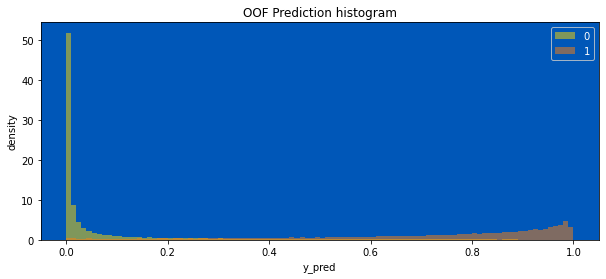

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

# Calibration diagram

The calibration diagram shows how the model predicts the default probability of customers:

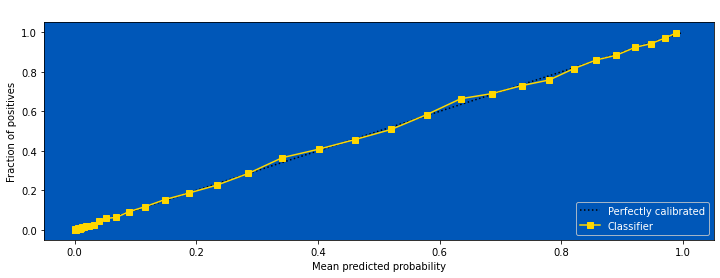

In [ ]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

We submit the mean of the five predictions. As proposed by @lucasmorin, we [take the mean of the log odds](https://www.kaggle.com/competitions/amex-default-prediction/discussion/329103) rather than of the probabilities.

In [ ]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-2.712420
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-7.066859
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-3.380043
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.910776
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2.801714
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-4.680405
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.796503
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.193700
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-1.141851


As a final check, we verify that the test prediction distribution equals the validation prediction distribution. 

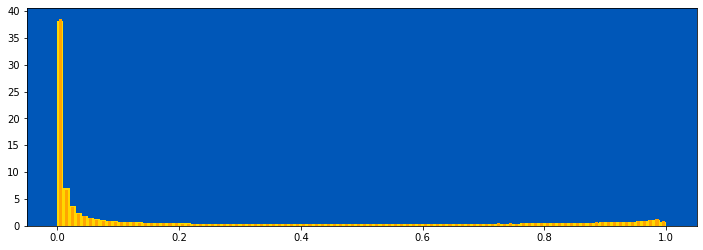

In [ ]:
if INFERENCE:
    plt.figure(figsize=(12, 4))
    plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
    plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='orange', density=True)
    plt.show()